In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/DSI1_trnrss.csv
/kaggle/input/DSI1_tstcrd.csv
/kaggle/input/MAN1_trncrd.csv
/kaggle/input/MAN1_trnrss_reduced.csv
/kaggle/input/MAN1_tstcrd.csv
/kaggle/input/MAN1_tstrss.csv
/kaggle/input/DSI1_tstrss.csv
/kaggle/input/MAN1_tstrss_clean.csv
/kaggle/input/MAN1_trnrss_clean.csv
/kaggle/input/DSI1_trncrd.csv
/kaggle/input/DSI1_trnrss_clean.csv
/kaggle/input/MAN1_trncrd_reduced.csv
/kaggle/input/MAN1_trnrss.csv
/kaggle/input/DSI1_tstrss_clean.csv


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time

In [11]:
def set_seed(seed):
    """
    Set random seed for reproducibility.
    - seed: Integer seed value.
    """
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed
    torch.manual_seed(seed)
    
    # If using CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Ensure deterministic behavior in PyTorch (slight impact on performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed before training

set_seed(42)

In [12]:
train_coords_file = "/kaggle/input/MAN1_trncrd_reduced.csv"
test_coords_file = "/kaggle/input/MAN1_tstcrd.csv"
train_clean_file = "/kaggle/input/MAN1_trnrss_reduced.csv"
test_clean_file = "/kaggle/input/MAN1_tstrss_clean.csv"

In [13]:
# File paths
# data_path = "/kaggle/input/wifi-dataset-tfm/"
# train_coords_file = data_path + "MAN1_trncrd.csv"
# test_coords_file = data_path + "MAN1_tstcrd.csv"
# train_clean_file = data_path + "MAN1_trnrss_clean.csv"
# test_clean_file = data_path + "MAN1_tstrss_clean.csv"



# Load data
train_coords = pd.read_csv(train_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
train_rss = pd.read_csv(train_clean_file, header=None)
test_coords = pd.read_csv(test_coords_file, header=None, names=["x", "y", "z", "floor", "building"])
test_rss = pd.read_csv(test_clean_file, header=None)


In [14]:
# Automatically determine dimensions
coord_dim = train_coords.shape[1]  # Number of columns in the coordinates file
rss_dim = train_rss.shape[1]       # Number of APs in the RSS data

# Replace invalid RSS values (100) with NaN
train_rss.replace(100, np.nan, inplace=True)
test_rss.replace(100, np.nan, inplace=True)

# Automatically calculate RSS_MIN and RSS_MAX, ignoring NaN values
RSS_MIN = train_rss.min().min()  # Minimum valid RSS value
RSS_MAX = train_rss.max().max()  # Maximum valid RSS value

# Replace NaN with a neutral value (e.g., RSS_MIN - 20)
neutral_value = RSS_MIN - 20
train_rss.fillna(neutral_value, inplace=True)
test_rss.fillna(neutral_value, inplace=True)

In [15]:
# Function to normalize RSS values
def normalize_rss(rss_matrix, rssi_min, rssi_max):
    """
    Normalize RSS values to the range [0, 1], ensuring NaN handling is safe.
    """
    rss_normalized = (rssi_max - rss_matrix) / (rssi_max - rssi_min)
    rss_normalized = rss_normalized.clip(0, 1)  # Ensure all values are in [0, 1]
    return rss_normalized

In [16]:
def denormalize_rss(rss_normalized, rssi_min, rssi_max):
    """
    Denormalize RSS values from the range [0, 1] back to their original scale.
    """
    rss_matrix = rssi_max - (rss_normalized * (rssi_max - rssi_min))
    return rss_matrix

In [17]:
# Normalize RSS data
train_rss_normalized = normalize_rss(train_rss.values, RSS_MIN, RSS_MAX)
test_rss_normalized = normalize_rss(test_rss.values, RSS_MIN, RSS_MAX)

# Combine coordinates and normalized RSS values
train_data = np.hstack((train_coords.values, train_rss_normalized))
test_data = np.hstack((test_coords.values, test_rss_normalized))

# Save processed data (optional)
# np.save(data_path + "train_data.npy", train_data)
# np.save(data_path + "test_data.npy", test_data)

print(f"Preprocessing completed. Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")

Preprocessing completed. Train data shape: (1300, 33), Test data shape: (460, 33)


In [18]:
def create_sketch(rss_matrix, neutral_value):
    """
    Create a 0-1 sketch where 1 indicates a missing (neutral) value and 0 indicates valid RSS.
    """
    sketch = (rss_matrix == neutral_value).astype(float)  # 1 for missing, 0 for valid
    return sketch

# Create sketches for train and test data
train_sketch = create_sketch(train_rss.values, neutral_value)
test_sketch = create_sketch(test_rss.values, neutral_value)

# # Save sketches (optional)
# np.save(data_path + "train_sketch.npy", train_sketch)
# np.save(data_path + "test_sketch.npy", test_sketch)

print(f"Sketches created. Train sketch shape: {train_sketch.shape}, Test sketch shape: {test_sketch.shape}")


Sketches created. Train sketch shape: (1300, 28), Test sketch shape: (460, 28)


In [19]:
# Generator

class Generator(nn.Module):
    def __init__(self, coord_dim, noise_dim, sketch_dim, rss_dim):
        super(Generator, self).__init__()
        input_dim = coord_dim + noise_dim + sketch_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Incrementar a 512 neuronas
            nn.LeakyReLU(0.2),          # Usar LeakyReLU
            nn.Linear(512, 1024),       # Añadir una capa con 1024 neuronas
            nn.LeakyReLU(0.2),
            nn.Linear(1024, rss_dim),   # Salida igual al número de APs
            nn.Sigmoid()                # Salida normalizada [0, 1]
        )

    def forward(self, coords, noise, sketch):
        x = torch.cat((coords, noise, sketch), dim=1)
        return self.model(x)


In [20]:
# Discriminator 

class Discriminator(nn.Module):
    def __init__(self, coord_dim, rss_dim, sketch_dim):
        """
        Discriminator that takes coordinates, RSS data, and sketches as input.
        """
        super(Discriminator, self).__init__()
        input_dim = coord_dim + rss_dim + sketch_dim  # Combine all input dimensions
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Add dropout for regularization
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability of being real or fake
        )

    def forward(self, coords, rss, sketch):
        """
        Forward pass through the discriminator.
        - coords: Tensor of coordinates (x, y, z, floor, building).
        - rss: Tensor of RSS data.
        - sketch: Tensor of sketch data.
        """
        # Concatenate inputs along the feature dimension
        x = torch.cat((coords, rss, sketch), dim=1)
        return self.model(x)


In [21]:
def compute_hp(real_rss, fake_rss, threshold=-80):
    """
    Compute the proportion of signals heard simultaneously (HP).
    - real_rss: Tensor of real RSS values.
    - fake_rss: Tensor of generated RSS values.
    - threshold: RSS threshold to consider a signal as "heard".
    """
    real_heard = (real_rss > threshold).float()
    fake_heard = (fake_rss > threshold).float()
    heard_simultaneously = (real_heard * fake_heard).sum(dim=1)  # Element-wise AND
    total_real_heard = real_heard.sum(dim=1)

    # Avoid division by zero
    total_real_heard[total_real_heard == 0] = 1
    hp = (heard_simultaneously / total_real_heard).mean().item()
    return hp

def compute_rfp(real_rss, fake_rss):
    """
    Compute the Rational Fluctuation Proportion (RFP).
    - real_rss: Tensor of real RSS values.
    - fake_rss: Tensor of generated RSS values.
    """
    real_mean = real_rss.mean(dim=0)
    real_std = real_rss.std(dim=0)

    within_range = ((fake_rss >= (real_mean - real_std)) & (fake_rss <= (real_mean + real_std))).float()
    rfp = within_range.mean().item()  # Proportion of generated RSS within range
    return rfp

def compute_ris(fake_rss, classifier):
    """
    Compute the Inception Score (RIS) for generated RSS.
    - fake_rss: Tensor of generated RSS values.
    - classifier: Pretrained classifier to predict locations or classes.
    """
    # Get the predicted probabilities for each sample
    with torch.no_grad():
        predictions = classifier(fake_rss)
    
    # Compute conditional entropy H(c | y')
    p_c_given_y = predictions  # Conditional probabilities
    h_c_given_y = -torch.sum(p_c_given_y * torch.log(p_c_given_y + 1e-8), dim=1).mean()

    # Compute marginal entropy H(c)
    p_c = predictions.mean(dim=0)  # Marginal probabilities
    h_c = -torch.sum(p_c * torch.log(p_c + 1e-8))

    ris = torch.exp(h_c - h_c_given_y).item()
    return ris

In [22]:
#Training GAN
time_training = []
start_time = time.time()

set_seed(42)
sketch_dim = rss_dim
noise_dim = 100  # Latent noise dimension

G = Generator(coord_dim, noise_dim, sketch_dim, rss_dim)
D = Discriminator(coord_dim, rss_dim, sketch_dim)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Learning rate reducido
optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Learning rate reducido


# Loss function
criterion = nn.BCELoss()

# Training setup
epochs = 10000
batch_size = 64

# Convert data to tensors
train_coords_tensor = torch.tensor(train_coords.values, dtype=torch.float32)
train_rss_tensor = torch.tensor(train_rss_normalized, dtype=torch.float32)
train_sketch_tensor = torch.tensor(train_sketch, dtype=torch.float32)

# Define parameters for early stopping
patience = 500  # Number of epochs to wait for improvement
best_loss_G = float('inf')  # Track the best generator loss
epochs_without_improvement = 0  # Counter for epochs without improvement

for epoch in range(epochs):
    for i in range(0, train_coords_tensor.size(0), batch_size):
        # Select batch
        batch_coords = train_coords_tensor[i:i+batch_size]
        batch_rss = train_rss_tensor[i:i+batch_size]
        batch_sketch = train_sketch_tensor[i:i+batch_size]

        # Labels for real and fake data
        real_labels = torch.ones((batch_coords.size(0), 1))
        fake_labels = torch.zeros((batch_coords.size(0), 1))

        # Train Discriminator
        noise = torch.randn(batch_coords.size(0), noise_dim)
        fake_rss = G(batch_coords, noise, batch_sketch)

        D_real = D(batch_coords, batch_rss, batch_sketch)
        D_fake = D(batch_coords, fake_rss.detach(), batch_sketch)

        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_rss = G(batch_coords, noise, batch_sketch)
        D_fake = D(batch_coords, fake_rss, batch_sketch)
        loss_G = criterion(D_fake, real_labels)
        loss_G.backward()
        # Clipping de gradientes
        torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)      
        
        optimizer_G.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss D: {loss_D.item()} - Loss G: {loss_G.item()}")

    # Check for improvement in generator loss
    if loss_G.item() < best_loss_G:
        best_loss_G = loss_G.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Best Generator Loss: {best_loss_G:.4f}")
        break
    

Epoch 0/10000 - Loss D: 1.3847880363464355 - Loss G: 0.7130591869354248
Epoch 100/10000 - Loss D: 1.2888736724853516 - Loss G: 0.7594268321990967
Epoch 200/10000 - Loss D: 1.4134435653686523 - Loss G: 0.6924545764923096
Epoch 300/10000 - Loss D: 1.361816644668579 - Loss G: 0.7172147631645203
Epoch 400/10000 - Loss D: 1.3784617185592651 - Loss G: 0.7009440660476685
Epoch 500/10000 - Loss D: 1.3734012842178345 - Loss G: 0.6900447607040405
Early stopping triggered at epoch 591. Best Generator Loss: 0.6136


In [23]:
end_time = time.time()
total_time = end_time - start_time
time_training.append(total_time)
print("Training time = ", time_training[0])

Training time =  150.39956665039062


In [24]:
# Generate synthetic RSS data
num_samples = 1000  # Number of synthetic samples to evaluate
noise = torch.randn(num_samples, noise_dim)  # Generate random noise
sample_coords = train_coords_tensor[:num_samples]  # Use real coordinates as a base
sample_sketch = train_sketch_tensor[:num_samples]  # Use corresponding sketches

# Generate synthetic RSS
generated_rss = G(sample_coords, noise, sample_sketch)

print(f"Generated RSS shape: {generated_rss.shape}")

Generated RSS shape: torch.Size([1000, 28])


In [25]:
# Compute HP metric
hp_score = compute_hp(train_rss_tensor[:num_samples], generated_rss)
print(f"HP Score: {hp_score:.4f}")

# Compute RFP metric
rfp_score = compute_rfp(train_rss_tensor[:num_samples], generated_rss)
print(f"RFP Score: {rfp_score:.4f}")

HP Score: 1.0000
RFP Score: 0.7859


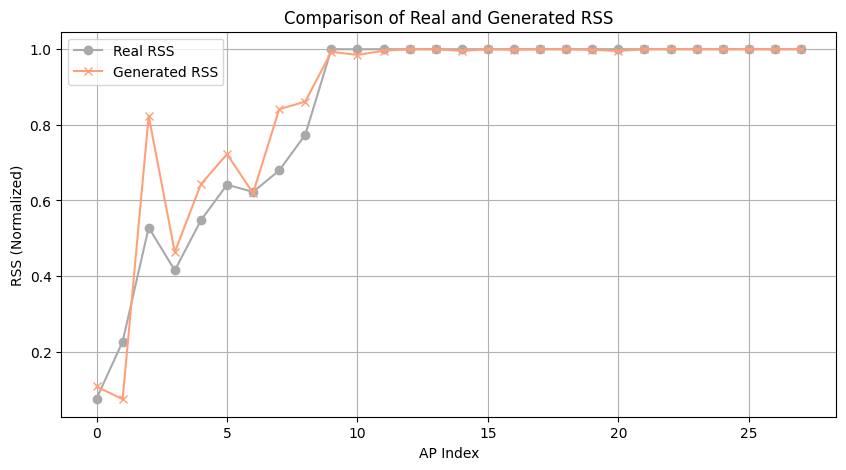

In [26]:
import matplotlib.pyplot as plt

# Select a sample index to compare
sample_index = 0

# Plot real vs generated RSS
plt.figure(figsize=(10, 5))
plt.plot(train_rss_tensor[sample_index].numpy(), label='Real RSS', marker='o', color='darkgray')
plt.plot(generated_rss[sample_index].detach().numpy(), label='Generated RSS', marker='x', color = '#FFA07A')
plt.xlabel('AP Index')
plt.ylabel('RSS (Normalized)')
plt.title('Comparison of Real and Generated RSS')
plt.legend()
plt.grid()
plt.show()

## Generate data

In [27]:
def generate_synthetic_data(generator, real_coords, real_sketch, noise_dim, synthetic_percentage=20):
    """
    Generate synthetic RSS data using the trained generator.
    - generator: Trained generator model.
    - real_coords: Tensor of real coordinates.
    - real_sketch: Tensor of sketches for the real data.
    - noise_dim: Dimension of the noise vector.
    - synthetic_percentage: Percentage of synthetic data to generate relative to real data.
    """
    # Calculate the number of synthetic samples to generate
    num_real_samples = real_coords.size(0)
    num_synthetic_samples = int(num_real_samples * synthetic_percentage / 100)
    
    # Generate synthetic data
    noise = torch.randn(num_synthetic_samples, noise_dim)
    synthetic_coords = real_coords[:num_synthetic_samples]  # Repeat or sample real coordinates
    synthetic_sketch = real_sketch[:num_synthetic_samples]  # Repeat or sample real sketches
    synthetic_rss = generator(synthetic_coords, noise, synthetic_sketch)
    
    # Combine real and synthetic data
    combined_coords = torch.cat((real_coords, synthetic_coords), dim=0)
    combined_rss = torch.cat((train_rss_tensor, synthetic_rss), dim=0)
    
    return combined_coords, combined_rss, synthetic_coords, synthetic_rss


In [28]:
# Function to plot a heatmap for a specific AP
def plot_rss_heatmap(coords, rss, ap_index, title, null_value=100):
    """
    Plots a heatmap where color intensity represents the RSS value for a specific AP.

    Parameters:
        coords (DataFrame or ndarray): DataFrame with coordinates (x, y) or ndarray.
        rss (DataFrame or ndarray): DataFrame or ndarray with RSS values for each AP.
        ap_index (int): Index of the AP to plot.
        title (str): Title of the plot.
        null_value (int): Value representing null RSS measurements (default: 100).
    """
    # Extract the AP's RSS values and replace null values with a neutral value
    if isinstance(rss, pd.DataFrame):  # If RSS is a DataFrame
        ap_rss = rss.iloc[:, ap_index].replace(null_value, neutral_value)
    else:  # If RSS is a Numpy array
        ap_rss = np.where(rss[:, ap_index] == null_value, neutral_value, rss[:, ap_index])

    # Extract x and y coordinates
    if isinstance(coords, pd.DataFrame):  # If coords is a DataFrame
        x = coords["x"]
        y = coords["y"]
    else:  # If coords is a Numpy array
        x = coords[:, 0]
        y = coords[:, 1]

    # Use global RSS_MIN and RSS_MAX for color scale
    vmin = RSS_MIN
    vmax = RSS_MAX

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x, y, c=ap_rss, cmap="viridis", vmin=vmin, vmax=vmax)
    plt.colorbar(scatter, label="RSS (dBm)")
    plt.title(f"Heatmap of RSS {title} for AP {ap_index} ")
    plt.xlim(-26, 35)  
    plt.ylim(-20, 14) 
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

In [29]:
# Generate synthetic data (60% additional samples)
synthetic_percentage = 60
set_seed(42)
combined_coords, combined_rss, synthetic_coords, synthetic_rss = generate_synthetic_data(
    G, train_coords_tensor, train_sketch_tensor, noise_dim, synthetic_percentage
)

print(f"Combined data shape: {combined_coords.shape}, {combined_rss.shape}")

Combined data shape: torch.Size([2080, 5]), torch.Size([2080, 28])


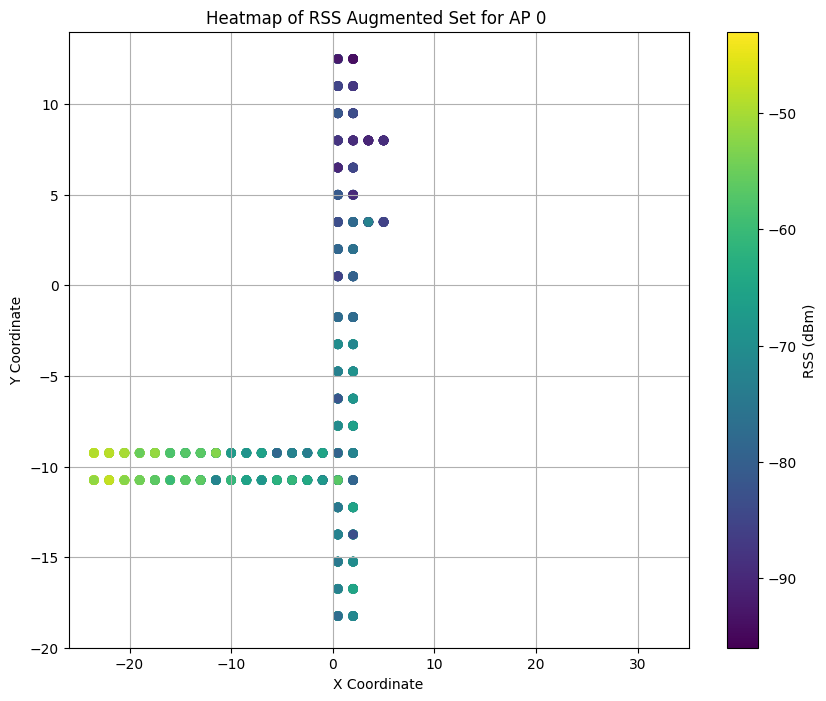

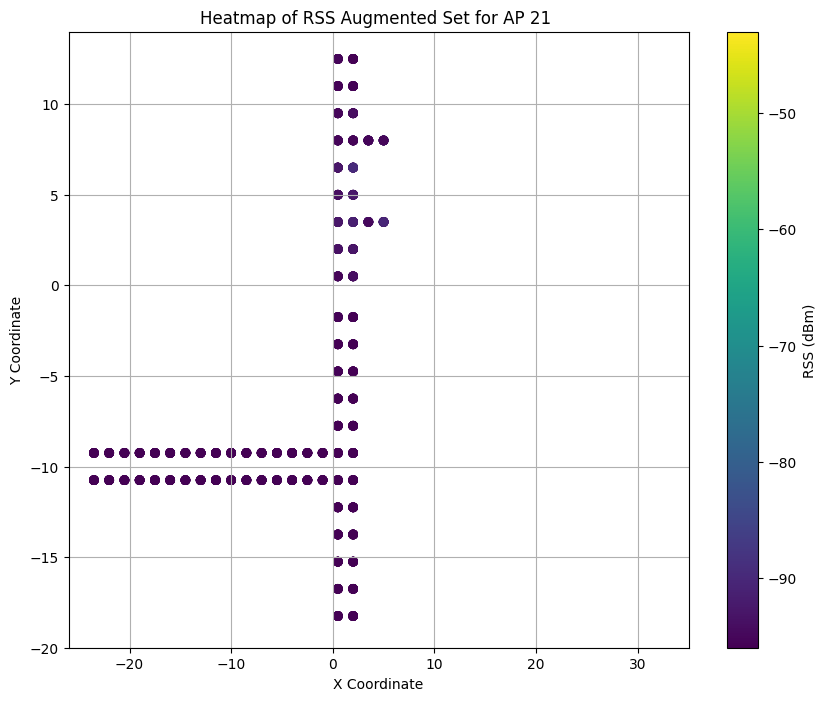

In [30]:
# Convert tensors to numpy arrays
synthetic_coords_np = synthetic_coords.detach().numpy()  # Detach to remove gradients
synthetic_rss_np = synthetic_rss.detach().numpy()        # Detach to remove gradients

synthetic_rss_np_desnormalized = denormalize_rss(synthetic_rss_np, RSS_MIN, RSS_MAX)


# Example usage
ap_indices = [0, 21] 
for ap_index in ap_indices:
    plot_rss_heatmap(synthetic_coords_np, synthetic_rss_np_desnormalized, ap_index, title=f"Augmented Set")

In [31]:
from collections import Counter

unique_coords, counts = np.unique(synthetic_coords_np, axis=0, return_counts=True)
mean_repetitions = np.mean(counts)
num_unique_coords = len(unique_coords)

print(f"Number of unique coordinates: {num_unique_coords}")
print(f"Average repetitions per unique point: {mean_repetitions:.2f}")

Number of unique coordinates: 78
Average repetitions per unique point: 10.00


## kNN

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Convert tensors to numpy arrays
combined_coords_np = combined_coords.detach().numpy()  # Detach to remove gradients
combined_rss_np = combined_rss.detach().numpy()        # Detach to remove gradients
test_coords_np = test_coords.values                   # Test coords are already in NumPy format
test_rss_np = test_rss_normalized                     # Test RSS is already normalized


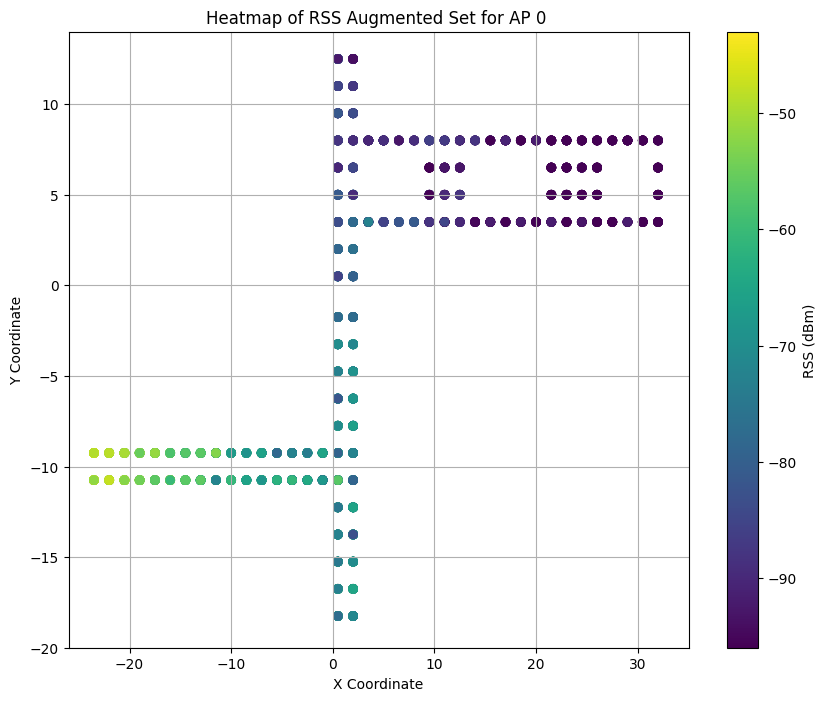

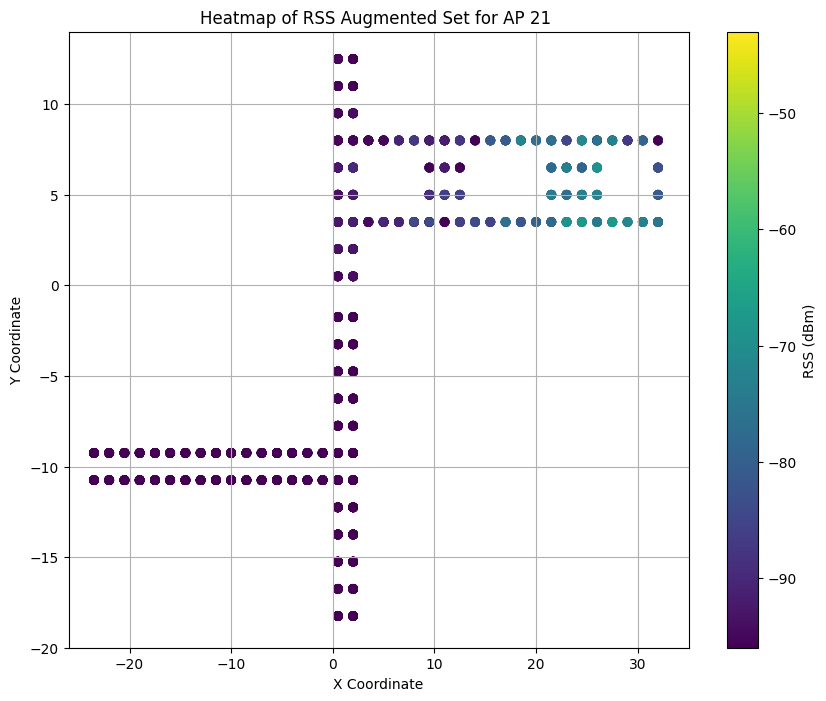

In [33]:
# Plot heatmaps combined for selected AP
combined_rss_np_desnormalized = denormalize_rss(combined_rss_np, RSS_MIN, RSS_MAX)
ap_indices = [0, 21] 
for ap_index in ap_indices:
    plot_rss_heatmap(combined_coords_np, combined_rss_np_desnormalized, ap_index, title=f"Augmented Set")

In [34]:
# Define range for k
k_values = range(1, 21)  # Test k from 1 to 20
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store results
cv_scores_real = []  # CV MSE scores for the model without synthetic data
cv_scores_synthetic = []  # CV MSE scores for the model with synthetic data

# Perform cross-validation for each k
for k in k_values:
    mse_real = []
    mse_synthetic = []

    # K-fold for model without synthetic data
    for train_idx, val_idx in kf.split(train_rss_normalized):
        X_train, X_val = train_rss_normalized[train_idx], train_rss_normalized[val_idx]
        y_train, y_val = train_coords.values[train_idx], train_coords.values[val_idx]

        knn_real = KNeighborsRegressor(n_neighbors=k)
        knn_real.fit(X_train, y_train)
        y_pred_val = knn_real.predict(X_val)
        mse_real.append(mean_squared_error(y_val, y_pred_val))
    
    # K-fold for model with synthetic data
    for train_idx, val_idx in kf.split(combined_rss_np):
        X_train, X_val = combined_rss_np[train_idx],combined_rss_np[val_idx]
        y_train, y_val = combined_coords_np[train_idx], combined_coords_np[val_idx]

        knn_synthetic = KNeighborsRegressor(n_neighbors=k)
        knn_synthetic.fit(X_train, y_train)
        y_pred_val = knn_synthetic.predict(X_val)
        mse_synthetic.append(mean_squared_error(y_val, y_pred_val))

    # Store average MSE for each k
    cv_scores_real.append(np.mean(mse_real))
    cv_scores_synthetic.append(np.mean(mse_synthetic))

# Find the optimal k
optimal_k_real = k_values[np.argmin(cv_scores_real)]
optimal_k_synthetic = k_values[np.argmin(cv_scores_synthetic)]

print(f"Optimal k (Without Synthetic Data): {optimal_k_real}")
print(f"Optimal k (With Synthetic Data): {optimal_k_synthetic}")


Optimal k (Without Synthetic Data): 9
Optimal k (With Synthetic Data): 6


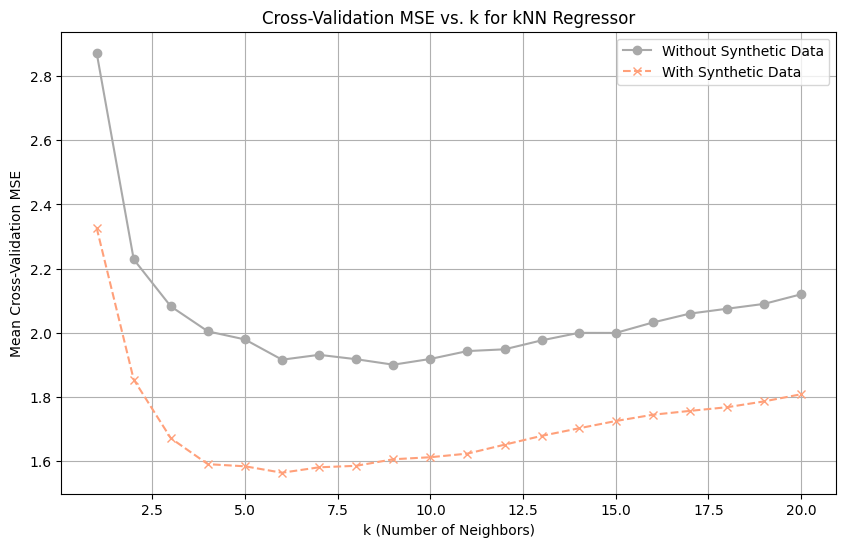

In [35]:
# Convert k_values to a list for plotting
k_values = list(k_values)

# Plot Cross-Validation MSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores_real, marker='o', linestyle='-', label='Without Synthetic Data', color='darkgray')
plt.plot(k_values, cv_scores_synthetic, marker='x', linestyle='--', label='With Synthetic Data', color='#FFA07A')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Cross-Validation MSE')
plt.title('Cross-Validation MSE vs. k for kNN Regressor')
plt.legend()
plt.grid()
plt.show()


In [36]:
# Define kNN regressor
knn = KNeighborsRegressor(n_neighbors=optimal_k_synthetic)

# Convert tensors to numpy arrays
combined_coords_np = combined_coords.detach().numpy()  # Detach to remove gradients
combined_rss_np = combined_rss.detach().numpy()        # Detach to remove gradients
test_coords_np = test_coords.values                   # Test coords are already in NumPy format
test_rss_np = test_rss_normalized                     # Test RSS is already normalized

# Train kNN regressor with enriched dataset
knn.fit(combined_rss_np, combined_coords_np)

# Evaluate on test set
predicted_coords = knn.predict(test_rss_np)

# Compute mean squared error (MSE)
mse = mean_squared_error(test_coords_np, predicted_coords)
print(f"Mean Squared Error (MSE) with synthetic data: {mse:.4f}")


Mean Squared Error (MSE) with synthetic data: 1.6749


In [37]:
# Train and evaluate kNN with only real data
knn_real = KNeighborsRegressor(n_neighbors=optimal_k_real)
knn_real.fit(train_rss_normalized, train_coords.values)
predicted_coords_real = knn_real.predict(test_rss_np)
mse_real = mean_squared_error(test_coords_np, predicted_coords_real)

print(f"Mean Squared Error (MSE) without synthetic data: {mse_real:.4f}")

Mean Squared Error (MSE) without synthetic data: 1.7725


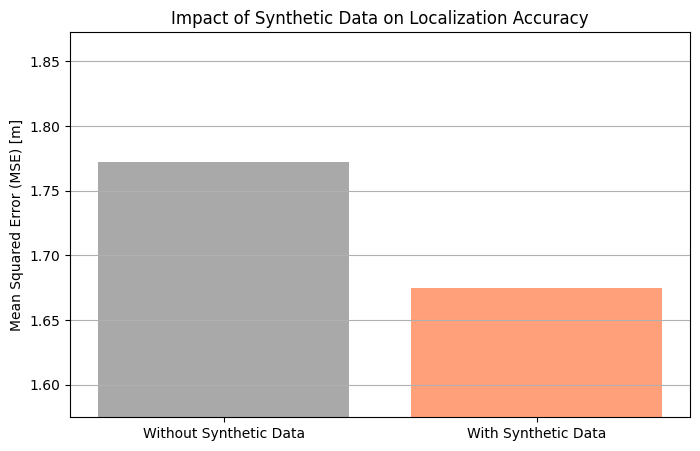

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# MSE values
mse_values = [mse_real, mse]
labels = ['Without Synthetic Data', 'With Synthetic Data']

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, mse_values, color=['darkgray', '#FFA07A'])
plt.ylabel('Mean Squared Error (MSE) [m]')
plt.title('Impact of Synthetic Data on Localization Accuracy')
plt.ylim(min(mse_values) - 0.1, max(mse_values) + 0.1)  # Adjust y-axis for clarity
plt.grid(axis='y')
plt.show()

In [39]:
synthetic_percentages = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
mse_values = []
time_computation = []

for percentage in synthetic_percentages:
    set_seed(42)
    start_time = time.time()
    combined_coords, combined_rss, synthetic_coords, synthetic_rss  = generate_synthetic_data(
        G, train_coords_tensor, train_sketch_tensor, noise_dim, synthetic_percentage=percentage
    )
    
    # Detach tensors before converting to NumPy
    combined_coords_np = combined_coords.detach().numpy()
    combined_rss_np = combined_rss.detach().numpy()
    
    # Train kNN regressor
    knn.fit(combined_rss_np, combined_coords_np)
    
    # Predict and calculate MSE
    predicted_coords = knn.predict(test_rss_np)
    mse = mean_squared_error(test_coords_np, predicted_coords)
    mse_values.append(mse)
    end_time = time.time()
    total_time = end_time - start_time
    time_computation.append(total_time)

In [40]:
mse_values_rounded = [round(value, 4) for value in mse_values]
time_computation = [round(value, 6) for value in time_computation]
print(synthetic_percentages)
print(mse_values_rounded)
print(time_computation)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[1.7339, 1.714, 1.7285, 1.7132, 1.6964, 1.6988, 1.6749, 1.7576, 1.8164, 1.8706, 1.8644]
[0.024297, 0.102669, 0.020997, 0.028626, 0.019434, 0.022254, 0.025894, 0.032441, 0.05084, 0.063835, 0.098449]


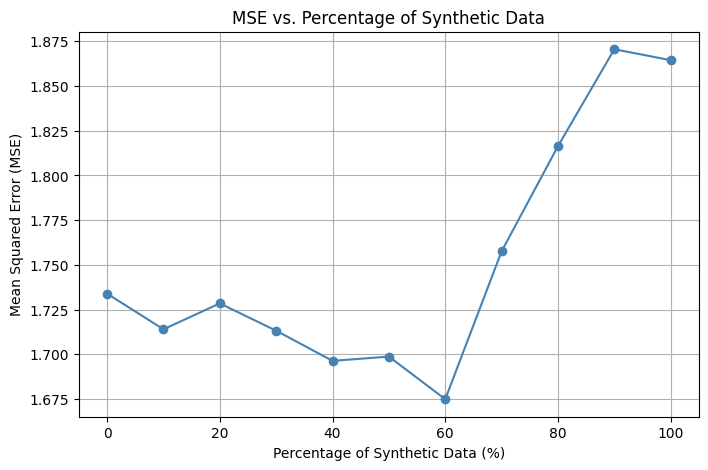

In [41]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(synthetic_percentages, mse_values, marker='o', linestyle='-', color='steelblue')
plt.xlabel('Percentage of Synthetic Data (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Percentage of Synthetic Data')
plt.grid()
plt.show()

In [42]:

def localization_accuracy(true_coords, pred_coords, threshold):
    """
    Calculate the percentage of predictions within a given distance threshold.
    - true_coords: Array of true coordinates (shape: n_samples x 3 or more).
    - pred_coords: Array of predicted coordinates (shape: n_samples x 3 or more).
    - threshold: Distance threshold (e.g., 2 meters, 5 meters).
    """
    # Compute Euclidean distances for the first 3 dimensions (x, y, z)
    distances = np.linalg.norm(true_coords[:, :3] - pred_coords[:, :3], axis=1)
    # Compute accuracy (percentage of distances <= threshold)
    accuracy = np.mean(distances <= threshold)
    return accuracy

In [43]:
# Thresholds (en metros)
thresholds = [0.5, 1, 2, 3, 4, 5, 6]

# # Seleccting the optimum % 
# synthetic_percentage = 10  # % generated data
# combined_coords, combined_rss, synthetic_coords, synthetic_rss = generate_synthetic_data(
#     G, train_coords_tensor, train_sketch_tensor, noise_dim, synthetic_percentage=synthetic_percentage
# )
# Without Synthetic Data
accuracy_real = {}
for threshold in thresholds:
    accuracy = localization_accuracy(test_coords_np, knn_real.predict(test_rss_np), threshold)
    accuracy_real[threshold] = accuracy
    print(f"Localization Accuracy (Without Synthetic Data, {threshold}m): {accuracy:.4f}")

# With Synthetic Data
accuracy_synthetic = {}
for threshold in thresholds:
    accuracy = localization_accuracy(test_coords_np, predicted_coords, threshold)
    accuracy_synthetic[threshold] = accuracy
    print(f"Localization Accuracy (With Synthetic Data, {threshold}m): {accuracy:.4f}")

# Calculate the percentage improvement for each threshold
improvement_percentages = {}

for threshold in thresholds:
    accuracy_real_value = accuracy_real[threshold]
    accuracy_synthetic_value = accuracy_synthetic[threshold]
    improvement = ((accuracy_synthetic_value - accuracy_real_value) / accuracy_real_value) * 100
    improvement_percentages[threshold] = improvement
    print(f"Threshold: {threshold}m - Improvement: {improvement:.2f}%")



Localization Accuracy (Without Synthetic Data, 0.5m): 0.0478
Localization Accuracy (Without Synthetic Data, 1m): 0.1761
Localization Accuracy (Without Synthetic Data, 2m): 0.4739
Localization Accuracy (Without Synthetic Data, 3m): 0.6957
Localization Accuracy (Without Synthetic Data, 4m): 0.8522
Localization Accuracy (Without Synthetic Data, 5m): 0.9239
Localization Accuracy (Without Synthetic Data, 6m): 0.9565
Localization Accuracy (With Synthetic Data, 0.5m): 0.0609
Localization Accuracy (With Synthetic Data, 1m): 0.1587
Localization Accuracy (With Synthetic Data, 2m): 0.4457
Localization Accuracy (With Synthetic Data, 3m): 0.6543
Localization Accuracy (With Synthetic Data, 4m): 0.8152
Localization Accuracy (With Synthetic Data, 5m): 0.9174
Localization Accuracy (With Synthetic Data, 6m): 0.9587
Threshold: 0.5m - Improvement: 27.27%
Threshold: 1m - Improvement: -9.88%
Threshold: 2m - Improvement: -5.96%
Threshold: 3m - Improvement: -5.94%
Threshold: 4m - Improvement: -4.34%
Threshold

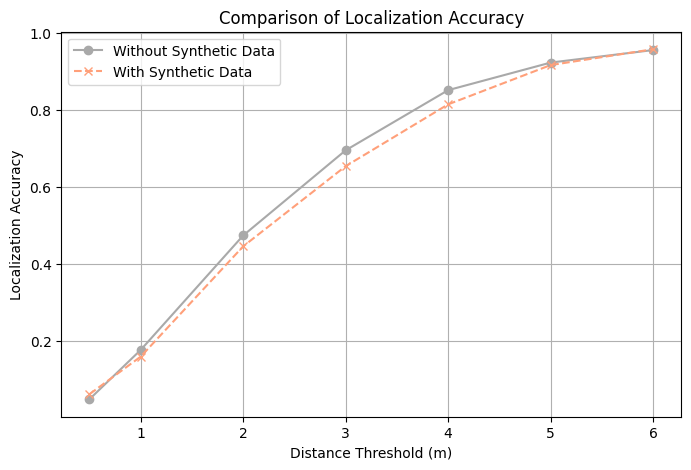

In [44]:
# Results
thresholds = list(accuracy_real.keys())
accuracies_real = list(accuracy_real.values())
accuracies_synthetic = list(accuracy_synthetic.values())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies_real, marker='o', linestyle='-', color='darkgray', label='Without Synthetic Data')
plt.plot(thresholds, accuracies_synthetic, marker='x', linestyle='--', color='#FFA07A', label='With Synthetic Data')
plt.xlabel('Distance Threshold (m)')
plt.ylabel('Localization Accuracy')
plt.title('Comparison of Localization Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Generate synthetic data (50% additional samples) FOR THE PLOT
synthetic_percentage_2 = 50
combined_coords_2, combined_rss_2, synthetic_coords_2, synthetic_rss_2 = generate_synthetic_data(
    G, train_coords_tensor, train_sketch_tensor, noise_dim, synthetic_percentage_2
)

print(f"Combined data shape: {combined_coords_2.shape}, {combined_rss_2.shape}")

Combined data shape: torch.Size([1950, 5]), torch.Size([1950, 28])


In [46]:
print(f"Combined data shape: {synthetic_coords_2.shape}, {synthetic_rss_2.shape}")

Combined data shape: torch.Size([650, 5]), torch.Size([650, 28])


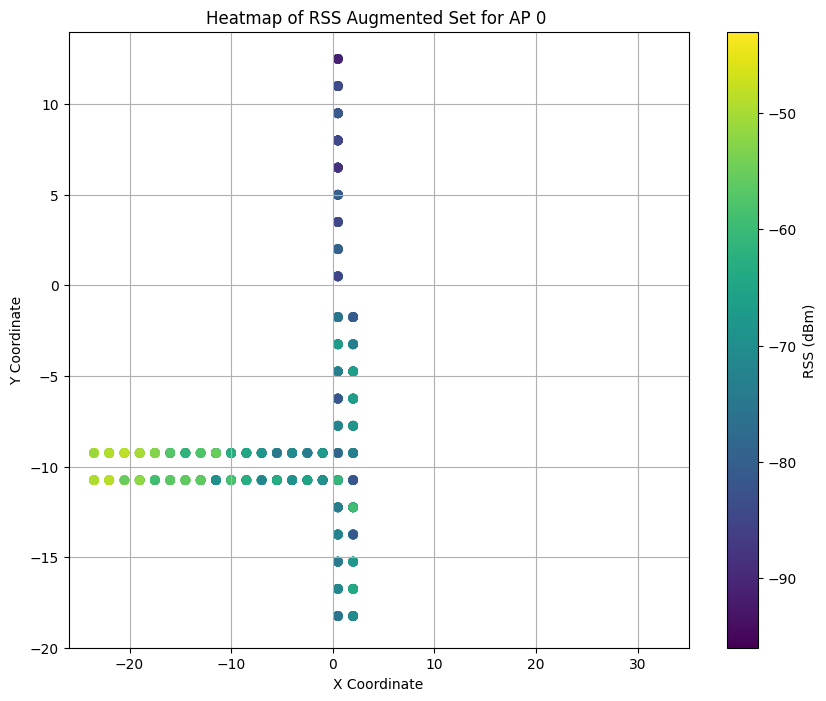

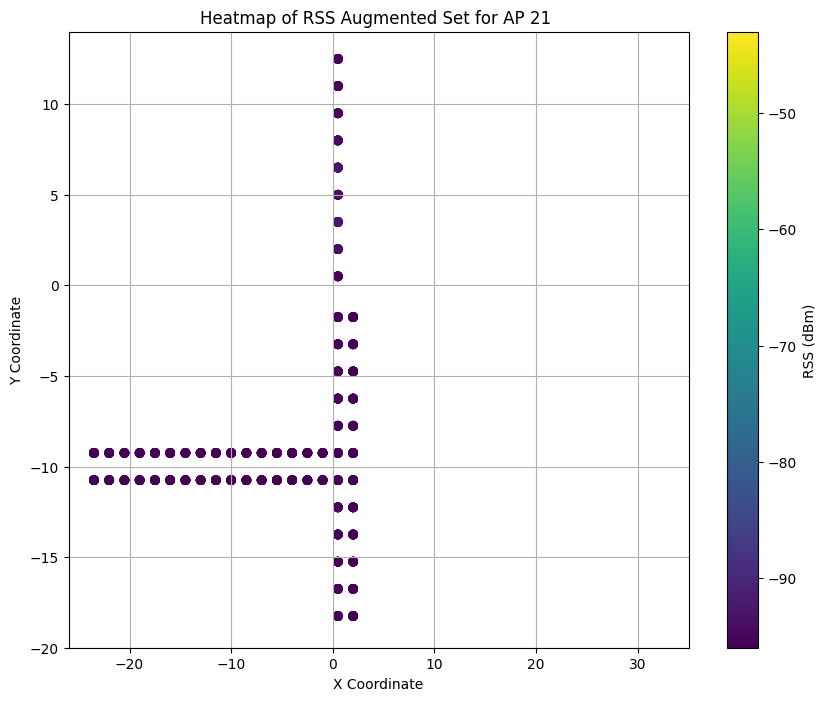

In [47]:
# Convert tensors to numpy arrays
synthetic_coords_np_2 = synthetic_coords_2.detach().numpy()  # Detach to remove gradients
synthetic_rss_np_2 = synthetic_rss_2.detach().numpy()        # Detach to remove gradients

synthetic_rss_np_desnormalized_2 = denormalize_rss(synthetic_rss_np_2, RSS_MIN, RSS_MAX)


# Example usage
ap_indices = [0, 21] 
for ap_index in ap_indices:
    plot_rss_heatmap(synthetic_coords_np_2, synthetic_rss_np_desnormalized_2, ap_index, title=f"Augmented Set")

In [48]:
from collections import Counter

unique_coords_2, counts_2 = np.unique(synthetic_coords_np_2, axis=0, return_counts=True)
mean_repetitions_2 = np.mean(counts_2)
num_unique_coords_2 = len(unique_coords_2)

print(f"Number of unique coordinates: {num_unique_coords_2}")
print(f"Average repetitions per unique point: {mean_repetitions_2:.2f}")

Number of unique coordinates: 65
Average repetitions per unique point: 10.00
